# Исследование свойст характеристики

## Подготовим вспомогательные инструменты для дальнейших исследований

In [2]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import networkx as nx

Генерация случайных величин, которые имеют распределение $Exp(λ)$ и $LogNormal(0, σ)$

In [128]:
def generate_exp(n, lam):
  return np.random.exponential(scale=1 / lam, size=n)

def generate_lognormal(n, sigma):
  return np.random.lognormal(mean=0, sigma=sigma, size=n)

**Построение KNN-графа** \
Построим KNN-граф на нашей случайной выборке $\Xi$

In [6]:
def build_knn_graph(k, vertices):
    v = np.asarray(vertices, dtype=float).reshape(-1, 1)
    n = v.shape[0]

    nbrs = NearestNeighbors(n_neighbors=k+1).fit(v)
    distances, indices = nbrs.kneighbors(v)

    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in indices[i][1:]:
            G.add_edge(i, j)

    return G

Фукнция, которая вычисялет минимальную степень вершины в графе

In [7]:
def min_degree(G: nx.Graph) -> int:
    return min(deg for _, deg in G.degree())

Фукнция, которая вычисялет кол-во компонент связности в графе

In [40]:
def num_connected_components(G: nx.Graph) -> int:
    return nx.number_connected_components(G)

**Построение дистанционного графа** \
Построим дистанционный граф на нашей случайной выборке $\Xi$

In [8]:

def build_distance_graph(d, vertices):
    v = np.asarray(vertices)
    n = v.size

    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in range(i+1, n):
            if abs(v[i] - v[j]) <= d:
                G.add_edge(i, j)

    return G

Фукнция, которая вычисялет кликовое число в графе

In [9]:
def get_clique_number(G: nx.Graph) -> int:
    return max((len(clique) for clique in nx.find_cliques(G)), default=0)

**метод Монте-Карло**

In [10]:
def monte_carlo(M, n, distr_param, graph_param, gen_func, graph_func, res_func):
  """
  Функция для реализации метода Монте-Карло.
  M - кол-во исследований.
  n - кол-во вершин в графе.
  distr_param - distribution parameter, параметр распределения.
  graph_param - параметр графа, то есть k - для KNN-графа или d - для дистанционного графа.
  gen_func - функция для генерации реализации распределения: genrate_lognormal или genrate_exp.
  graph_func - функция для построения графа: build_knn_graph или build_distance_graph.
  res_func - функция для вычисления характеристики графа: min_degree или get_clique_number.
  """
  results = []
  for _ in range(M):
    vertices = gen_func(n, distr_param)
    G = graph_func(graph_param, vertices)
    results.append(res_func(G))
  return results

In [123]:
from joblib import Parallel, delayed

def monte_carlo_step(n, distr_param, graph_param, gen_func, graph_func, res_func):
    vertices = gen_func(n, distr_param)
    G = graph_func(graph_param, vertices)
    return res_func(G)

def monte_carlo_multiprocessing(M, n, distr_param, graph_param, gen_func, graph_func, res_func):
  """
  Функция для реализации метода Монте-Карло с параллельными вычислениями.
  M - кол-во исследований.
  n - кол-во вершин в графе.
  distr_param - distribution parameter, параметр распределения.
  graph_param - параметр графа, то есть k - для KNN-графа или d - для дистанционного графа.
  gen_func - функция для генерации реализации распределения: genrate_lognormal или genrate_exp.
  graph_func - функция для построения графа: build_knn_graph или build_distance_graph.
  res_func - функция для вычисления характеристики графа: min_degree или get_clique_number.
  """
  results = Parallel(n_jobs=-1)(delayed(monte_carlo_step)(n, distr_param, graph_param, gen_func, graph_func, res_func) for _ in range(M))
  return results

Функция для вычисления базовых статистических метрик: среднее значение, дисперсия, стандартное отклонение, стандартная ошибка среднего.

In [11]:
import math

def compute_stats(arr):
    mean = np.mean(arr)
    var = np.var(arr, ddof=1)
    std = math.sqrt(var)
    se = std / math.sqrt(len(arr))
    return mean, var, std, se

Функция для анализа результатов и построения гистограммы.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [53]:
def analyze(n, graph_param, exp_results, lognormal_results, need_hist=True):
    mean_exp, var_exp, std_exp, se_exp = compute_stats(exp_results)
    mean_log, var_log, std_log, se_log = compute_stats(lognormal_results)
    p95_exp = np.percentile(exp_results, 95)
    threshold = (mean_exp + mean_log) / 2

    alpha = np.mean(exp_results > p95_exp)
    power = np.mean(lognormal_results > p95_exp)


    metrics = {
        'n': n, 'graph_param': graph_param,
        'power': power,
        'alpha': alpha,
        'p95_exp': p95_exp,
        'threshold': threshold,
        'mean_exp': mean_exp, 'var_exp': var_exp, 'std_exp': std_exp, 'se_exp': se_exp,
        'mean_log': mean_log, 'var_log': var_log, 'std_log': std_log, 'se_log': se_log,
    }

    if not need_hist:
        return metrics

    fig, ax = plt.subplots(figsize=(8, 5))
    bins = 'auto'

    ax.hist(exp_results, bins=bins, alpha=0.6, label='exp_results', density=True)
    ax.hist(lognormal_results, bins=bins, alpha=0.6, label='lognormal_results', density=True)

    ax.axvline(p95_exp, color='red', linestyle='--',
                label=f'95% exp ({p95_exp:.2f})')
    
    ax.axvline(threshold, color='darkblue', alpha=0.5, linestyle=':',
                label=f'threshold ({threshold:.2f})')

    ax.set_title(f'Гистограмма для n={n}, параметр графа={graph_param}\nМощность={power}, ошибка первого рода={alpha}')
    ax.set_xlabel('Значение характеристики')
    ax.set_ylabel('Плотность (frequency density)')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return metrics

## Исследуем, как ведет себя $Τ$ в зависимости от параметров процедуры построения графа и размера выборки

Зафиксируем параметры распределения: 
* $Exp(λ)$, $\; λ_0 = \frac{1}{\sqrt{e^2 - e}}$
* $LogNormal(0, \sigma)$, $\; \sigma_0 = 1$

In [12]:
import math

lam0 = 1/(math.sqrt(math.e**2 - math.e))
sigma0 = 1

#### Исследуем дистанционный-граф

In [131]:
M = 500
n_array = [25, 100, 500, 1000]
d_array = [
    [0.2, 0.4, 0.6],
    [0.1, 0.2, 0.3],
    [0.05, 0.1, 0.15],
    [0.01, 0.05, 0.1]
]

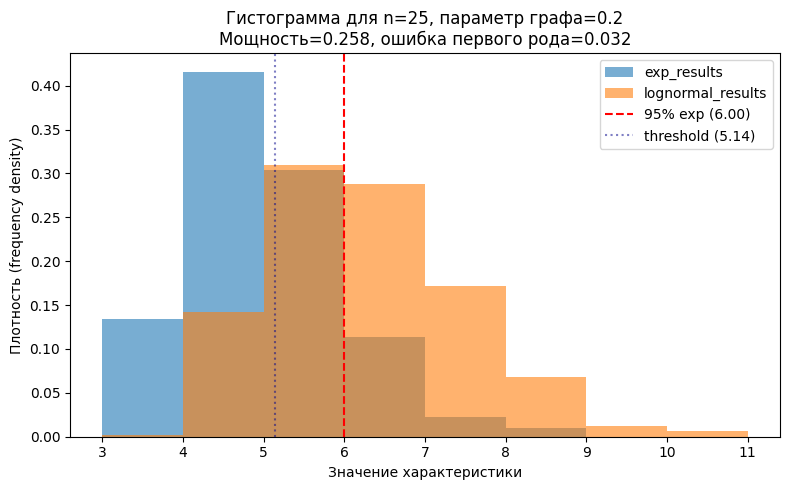

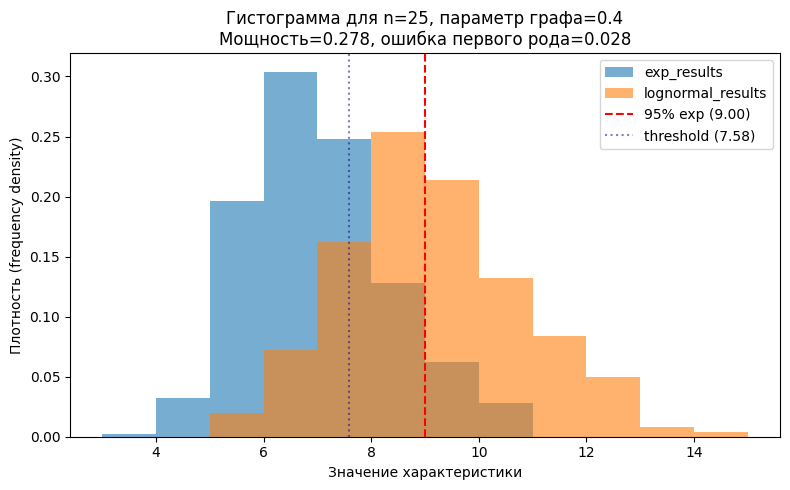

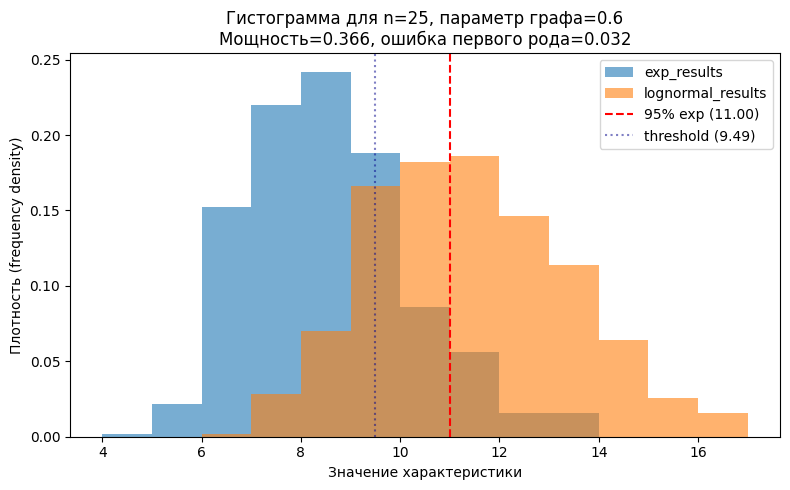

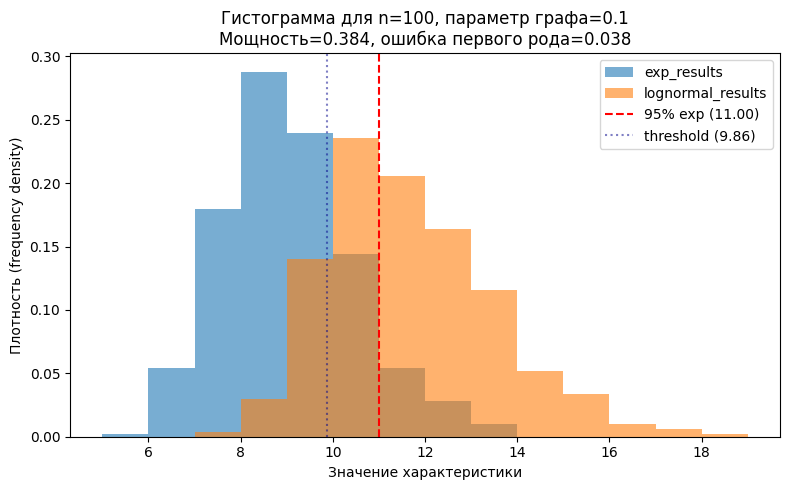

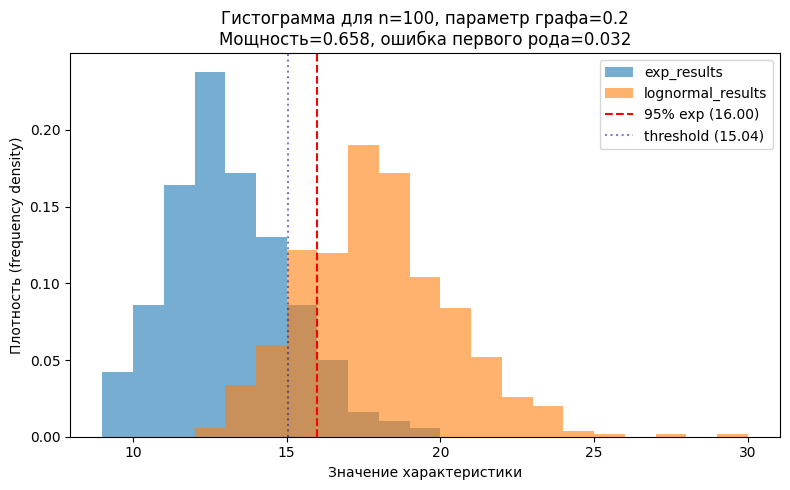

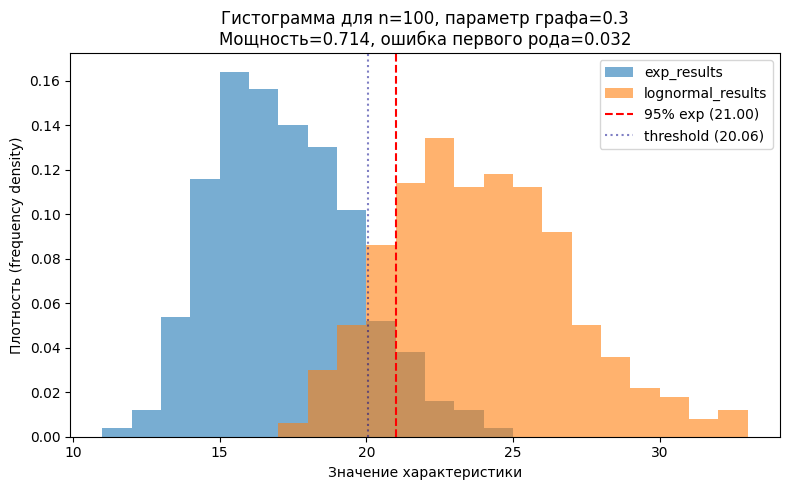

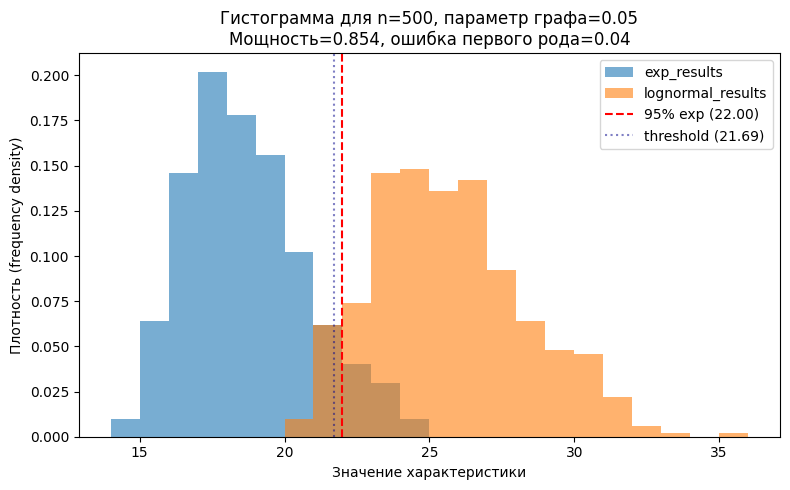

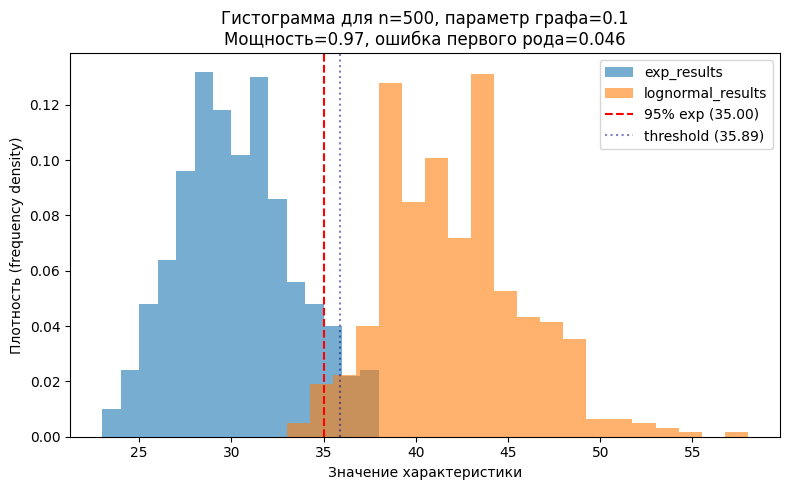

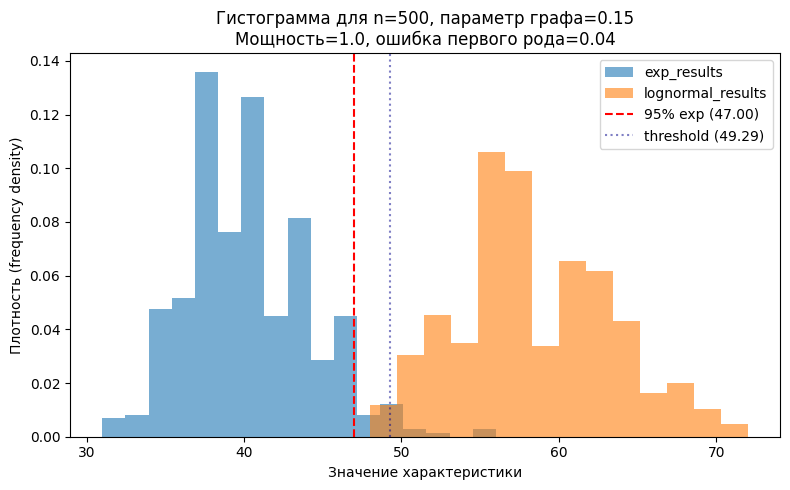

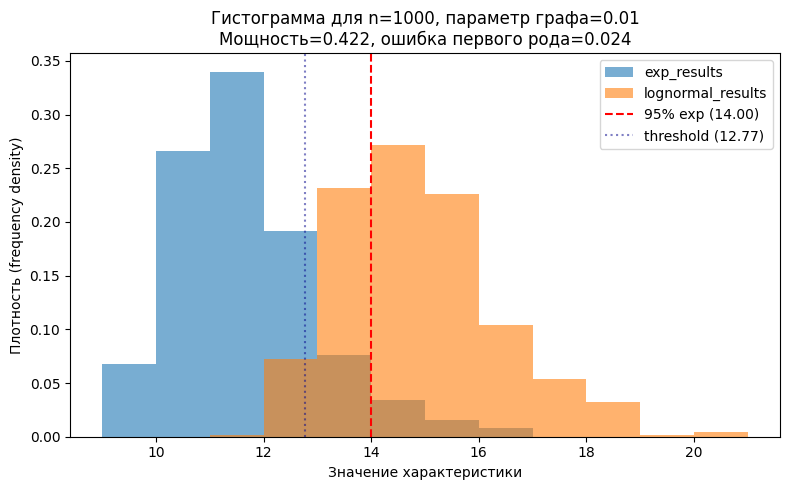

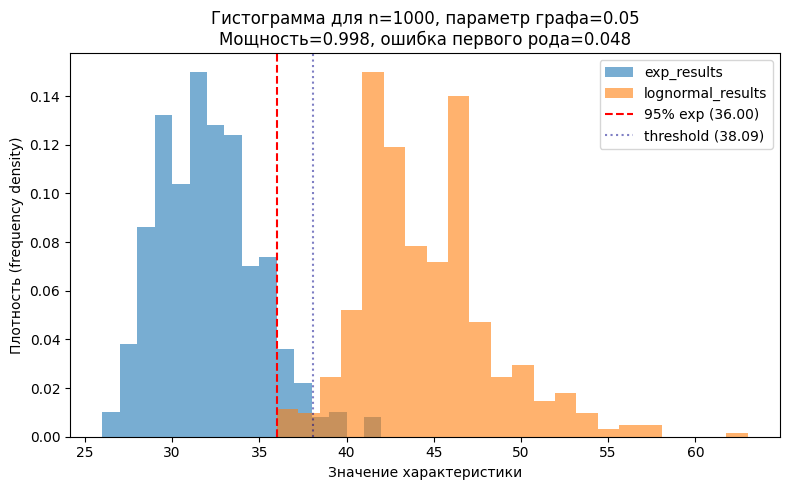

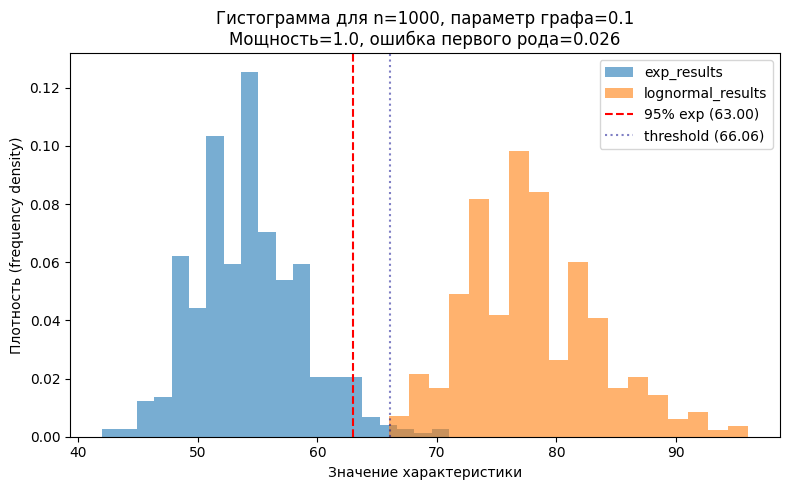

In [132]:
metrics_dist = []

for i, n in enumerate(n_array):
    for d in d_array[i]:
        exp_results = monte_carlo(M, n, lam0, d, generate_exp, build_distance_graph, get_clique_number)
        lognormal_results = monte_carlo(M, n, sigma0, d, generate_lognormal, build_distance_graph, get_clique_number)
        metrics_dist.append(analyze(n, d, exp_results, lognormal_results))


Выведем таблицу с основными статистическими метриками:

In [58]:
df_metrics = pd.DataFrame(metrics_dist)

In [59]:
df_metrics

,n,graph_param,power,alpha,p95_exp,threshold,mean_exp,var_exp,std_exp,se_exp,mean_log,var_log,std_log,se_log
0,25,0.20,0.238,0.042,6.00,5.202,4.600,1.090180,1.044117,0.046694,5.804,1.636858,1.279397,0.057216
1,25,0.40,0.254,0.014,9.00,7.459,6.406,1.744653,1.320853,0.059070,8.512,2.903663,1.704014,0.076206
2,25,0.60,0.302,0.032,11.00,9.329,7.994,2.466898,1.570636,0.070241,10.664,3.686477,1.920020,0.085866
3,100,0.10,0.414,0.028,11.00,9.828,8.414,1.974553,1.405188,0.062842,11.242,2.889214,1.699769,0.076016
4,100,0.20,0.622,0.036,16.00,15.171,12.852,3.974044,1.993500,0.089152,17.490,6.134168,2.476725,0.110763
5,100,0.30,0.742,0.044,21.00,20.185,16.758,6.356148,2.521140,0.112749,23.612,10.253964,3.202181,0.143206
6,500,0.05,0.942,0.050,21.05,21.552,18.104,3.949082,1.987230,0.088872,25.000,6.601202,2.569281,0.114902
7,500,0.10,0.956,0.040,36.00,36.251,30.168,10.893563,3.300540,0.147605,42.334,16.110665,4.013809,0.179503
8,500,0.15,0.990,0.048,47.00,49.196,40.648,16.144385,4.018008,0.179691,57.744,20.976417,4.580002,0.204824
9,1000,0.01,0.728,0.038,13.00,12.846,11.094,1.620405,1.272951,0.056928,14.598,2.693784,1.641275,0.073400


**Вывод:**\
Могу предположить, что при росте `n` метрики увеличиваются, данная зависимость похожа на линейную. Думаю, что на данный момент оптимальным `n = 500`, так как он дает хорошие метрики и довольно быстро работает. \
С `d` ситуация сложнее: предполагаю, что при фиксированном `n` метрики зависят параболически от `d`, так как при большом `d` граф становится слишком плотный, следовательно, теряет информацию. 

Поэтому я решил сделать еще одно исследование: зафиксировать `n = 500` и посмотреть как ведут себя метрики прри измении `d` в более широком диапазоне.

Для `n > 500` и `d > 0.3` скорость расчетов уже довольно низкая, поэтому у меня появилась идея распараллелить все вычисления.

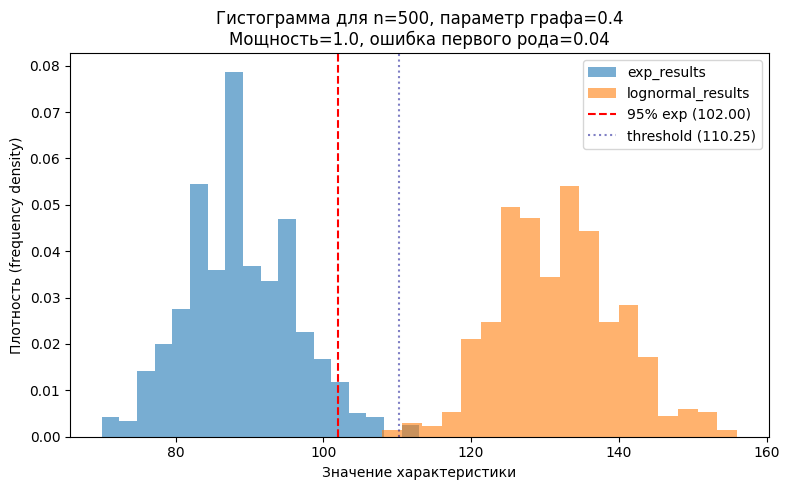

In [136]:
M = 500
N = 500
D = 0.4
metrics_dist_500 = []

exp_results = monte_carlo(M, N, lam0, D, generate_exp, build_distance_graph, get_clique_number)
lognormal_results = monte_carlo(M, N, sigma0, D, generate_lognormal, build_distance_graph, get_clique_number)
metrics_dist_500.append(analyze(N, D, exp_results, lognormal_results))

Данный код отработал примерно за `10` минут, посмотрим, сколько потребуется времени параллельному методу Монте-Карло.

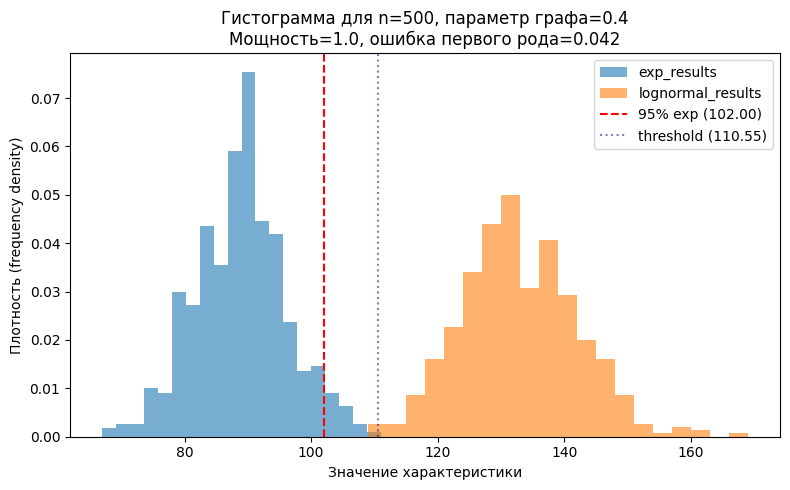

In [137]:
M = 500
N = 500
D = 0.4

exp_results = monte_carlo_multiprocessing(M, N, lam0, D, generate_exp, build_distance_graph, get_clique_number)
lognormal_results = monte_carlo_multiprocessing(M, N, sigma0, D, generate_lognormal, build_distance_graph, get_clique_number)
metrics_dist_500.append(analyze(N, D, exp_results, lognormal_results))

In [138]:
df_metrics = pd.DataFrame(metrics_dist_500)

In [139]:
df_metrics

,n,graph_param,power,alpha,p95_exp,threshold,mean_exp,var_exp,std_exp,se_exp,mean_log,var_log,std_log,se_log
0,500,0.4,1.0,0.040,102.0,110.25,88.784,55.664673,7.460876,0.333661,131.716,64.664673,8.041435,0.359624
1,500,0.4,1.0,0.042,102.0,110.55,88.784,52.402148,7.238933,0.323735,132.316,82.857860,9.102629,0.407082


Параллельный метод Монте-Карло отработал за `2` минуты при `n = 500` и `k = 0.4`, то есть мы получили прирост в скорости примерно в 5 раз. Теперь можем быстро посчитать, как влияет параметр `k` на метрики при фиксированном `n`.

In [147]:
M = 500
N = 500
d_array = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

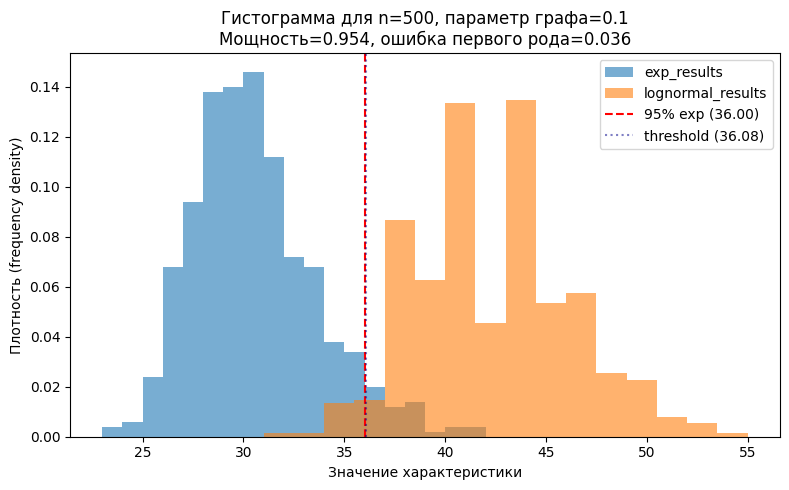

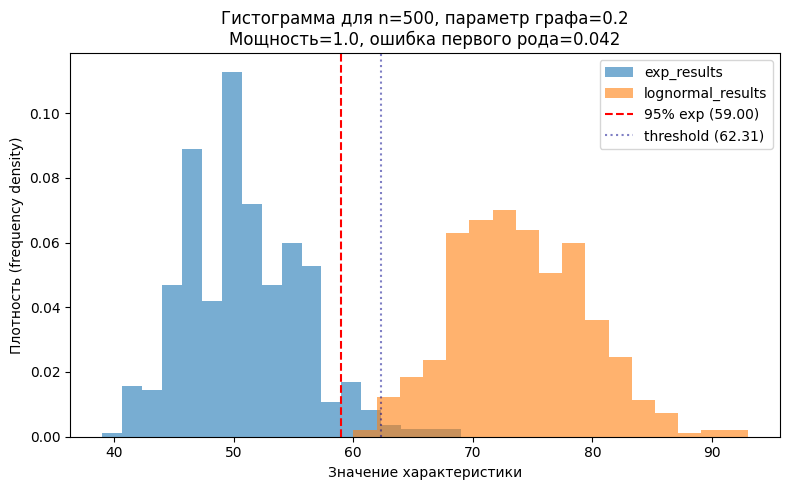

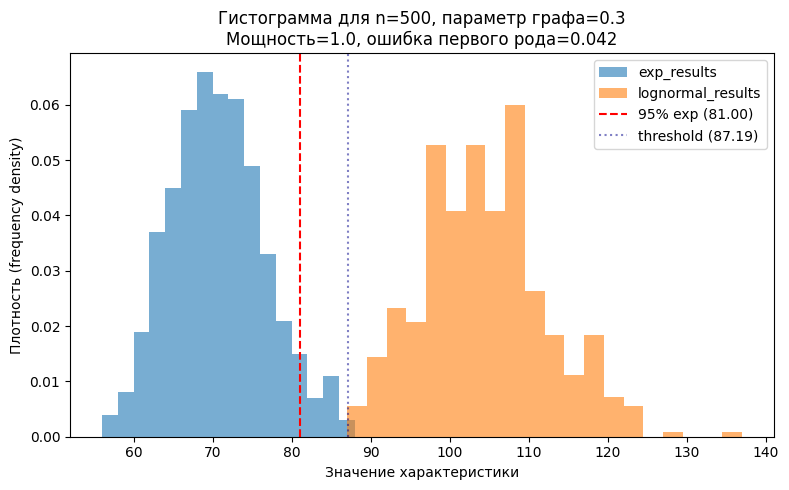

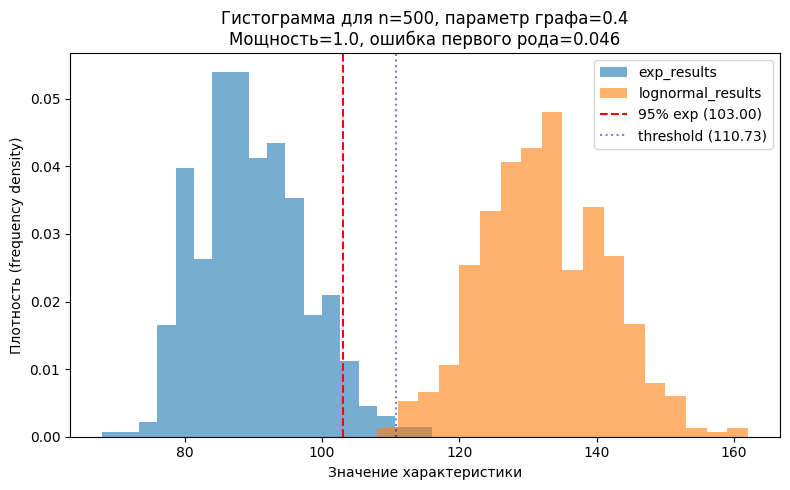

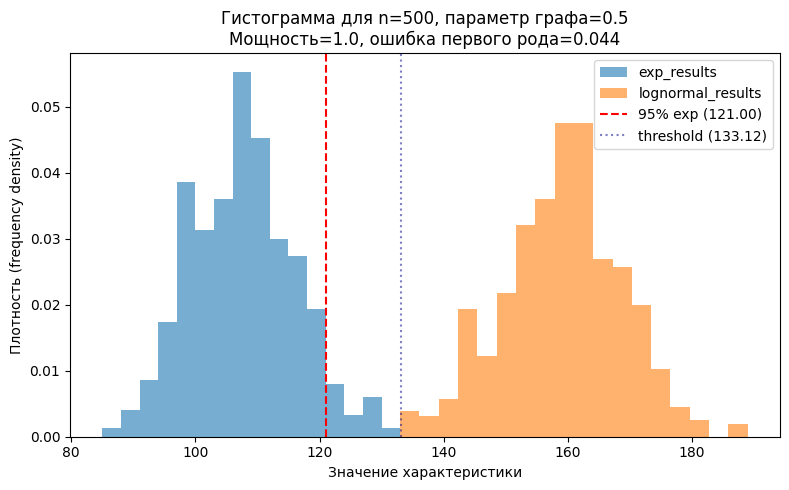

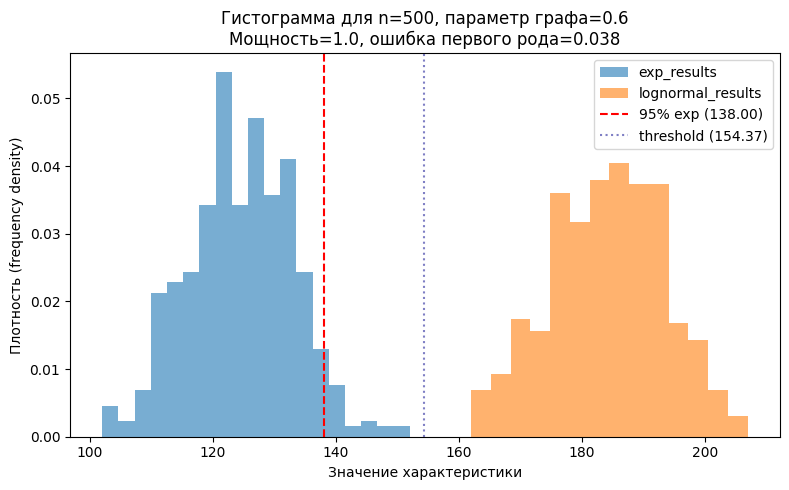

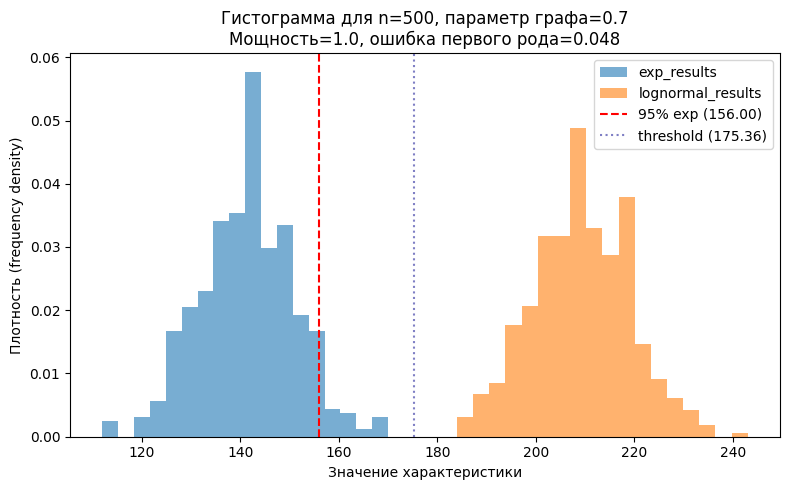

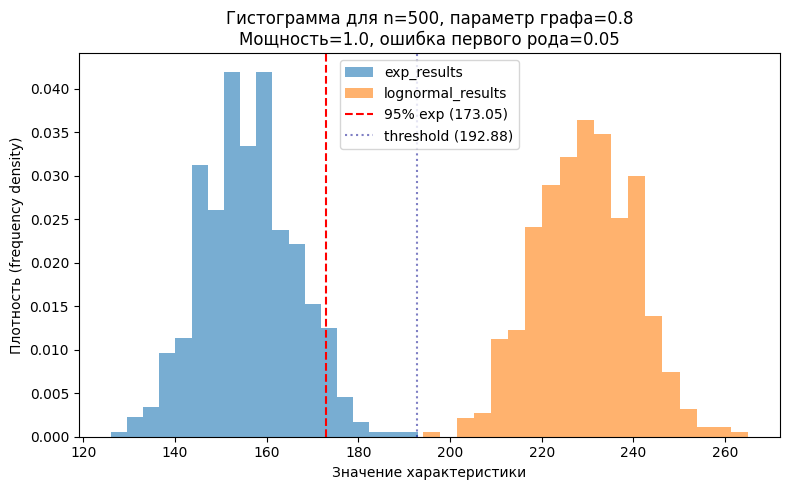

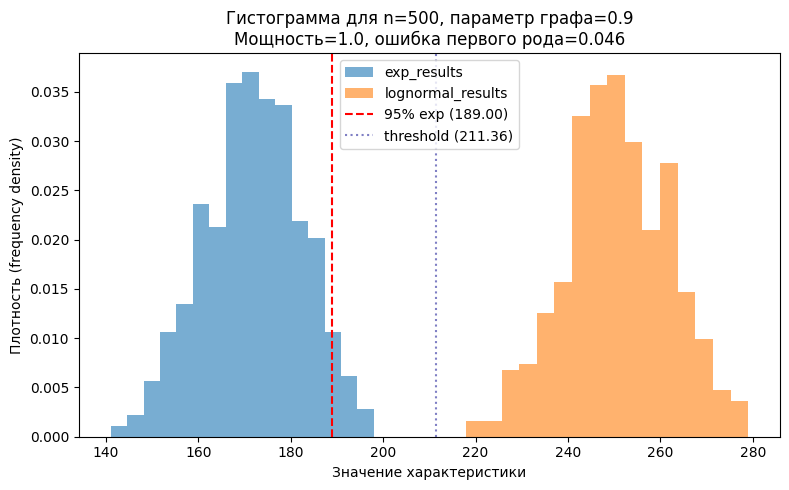

In [148]:
metrics_dist_500 = []

for d in d_array:
    exp_results = monte_carlo_multiprocessing(M, N, lam0, d, generate_exp, build_distance_graph, get_clique_number)
    lognormal_results = monte_carlo_multiprocessing(M, N, sigma0, d, generate_lognormal, build_distance_graph, get_clique_number)
    metrics_dist_500.append(analyze(N, d, exp_results, lognormal_results))

df_metrics = pd.DataFrame(metrics_dist_500)

In [149]:
df_metrics

,n,graph_param,power,alpha,p95_exp,threshold,mean_exp,var_exp,std_exp,se_exp,mean_log,var_log,std_log,se_log
0,500,0.1,0.954,0.036,36.00,36.080,30.048,9.420537,3.069289,0.137263,42.112,14.368192,3.790540,0.169518
1,500,0.2,1.000,0.042,59.00,62.307,50.690,23.532966,4.851079,0.216947,73.924,31.970164,5.654217,0.252864
2,500,0.3,1.000,0.042,81.00,87.188,70.220,35.983567,5.998630,0.268267,104.156,61.454573,7.839297,0.350584
3,500,0.4,1.000,0.046,103.00,110.734,89.594,59.107379,7.688132,0.343824,131.874,81.092309,9.005127,0.402722
4,500,0.5,1.000,0.044,121.00,133.116,107.148,71.204505,8.438276,0.377371,159.084,91.768481,9.579587,0.428412
5,500,0.6,1.000,0.038,138.00,154.367,124.534,73.074994,8.548391,0.382296,184.200,84.925852,9.215522,0.412131
6,500,0.7,1.000,0.048,156.00,175.358,141.386,90.994994,9.539130,0.426603,209.330,98.221543,9.910678,0.443219
7,500,0.8,1.000,0.050,173.05,192.878,156.206,103.434433,10.170272,0.454828,229.550,114.744990,10.711909,0.479051
8,500,0.9,1.000,0.046,189.00,211.364,171.970,114.602305,10.705247,0.478753,250.758,127.795026,11.304646,0.505559


**Выводы:**\
Гипотеза о параболической зависимости метрик от `d` не подтвердилась. Было установлено, что при росте `n` и `d` метрики качества растут, но у `d` есть критический порог, после которого метрики растут незначительно или же вовсе не растут, этот порог для большинства `n` равен `d = 0.7`. 
Поэтому в дальнейших экспериментах я считаю разумно рассматривать дистанционные графы, в которых `d = 0.7`, так как это идеальный компромисс между качеством предсказания и скоростью работы.

#### Исследуем KNN-граф

In [ ]:
M = 500
n_array = [25, 100, 500, 1000]
k_array = [
    [2, 4, 7, 8, 9, 10, 12, 13, 16, 17, 22],
    [10, 12, 13, 16, 17, 22, 32, 64, 71],
    [32, 64, 100, 256, 316]
]

In [ ]:
metrics_knn = []

for i, n in enumerate(n_array):
    for k in k_array[i]:
        if k >= n:
            continue
        exp_results = monte_carlo(M, n, lam0, k, genrate_exp, build_knn_graph, min_degree)
        lognormal_results = monte_carlo(M, n, sigma0, k, generate_lognormal, build_knn_graph, min_degree)
        metrics_knn.append(analyze(n, k, exp_results, lognormal_results, need_hist=False))

Выведем таблицу с основными статистическими метриками:

In [ ]:
df_metrics = pd.DataFrame(metrics_knn)

In [ ]:
df_metrics

**Вывод:** \
Очевидно, что характеристика минимальная степень вершины для KNN-графа не очень оптимальная, потому что не дает никакой информации о графе, следовательно, и о распределении, так как у KNN-графа степень всех вершин равна `k`. Попробуем рассмотреть другую характеристику для KNN-графа. \
Я думаю, что будет целесообразно рассмотреть кол-во компонент связности в графе, так как у нас по сути задача классификации.

In [ ]:
metrics_knn = []

for n in n_array:
    for k in k_array:
        if k >= n:
            continue
        exp_results = monte_carlo(M, n, lam0, k, genrate_exp, build_knn_graph, num_connected_components)
        lognormal_results = monte_carlo(M, n, sigma0, k, generate_lognormal, build_knn_graph, num_connected_components)
        metrics_knn.append(analyze(n, k, exp_results, lognormal_results))

Выведем таблицу с основными статистическими метриками:

In [ ]:
df_metrics = pd.DataFrame(metrics_knn)

In [ ]:
df_metrics

## Исследуем, как ведет себя $Τ$ в зависимости от параметров распределения

#### Исследуем KNN-граф

In [75]:
n = 100
k = 10
d = 0.15

Для $Exp(\lambda)$

In [74]:
lam_array = [0.1, 0.25, 0.5, 1.0, 2.0, 4.0]

In [ ]:
for lam in lam_array:
    results = monte_carlo(M, n, lam, k, genrate_exp, build_knn_graph, min_degree)
    mean_val = np.mean(results)
    var_val = np.var(results, ddof=1)
    std_val = math.sqrt(var_val)
    se = std_val / math.sqrt(M)
    ci_lower = mean_val - 1.96 * se
    ci_upper = mean_val + 1.96 * se

    print(f"n={n}, k={k} -> mean = {mean_val:.4f}, var = {var_val:.4f}, 95% CI = ({ci_lower:.4f}, {ci_upper:.4f})")

Для $LogNormal(0, \sigma)$

In [ ]:
sigma_array = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0]

In [ ]:
for sigma in sigma_array:
    results = monte_carlo(M, n, sigma, k, generate_lognormal, build_knn_graph, min_degree)
    mean_val = np.mean(results)
    var_val = np.var(results, ddof=1)
    std_val = math.sqrt(var_val)
    se = std_val / math.sqrt(M)
    ci_lower = mean_val - 1.96 * se
    ci_upper = mean_val + 1.96 * se

    print(f"n={n}, k={k} -> mean = {mean_val:.4f}, var = {var_val:.4f}, 95% CI = ({ci_lower:.4f}, {ci_upper:.4f})")

#### Исследуем дистанционный-граф

Для $Exp(\lambda)$

In [ ]:
lam_array = [0.1, 0.25, 0.5, 1.0, 2.0, 4.0]

In [ ]:
for lam in lam_array:
    results = monte_carlo(M, n, lam, d, genrate_exp, build_distance_graph, get_clique_number)
    mean_val = np.mean(results)
    var_val = np.var(results, ddof=1)
    std_val = math.sqrt(var_val)
    se = std_val / math.sqrt(M)
    ci_lower = mean_val - 1.96 * se
    ci_upper = mean_val + 1.96 * se

    print(f"n={n}, d={d} -> mean = {mean_val:.4f}, var = {var_val:.4f}, 95% CI = ({ci_lower:.4f}, {ci_upper:.4f})")

Для $LogNormal(0, \sigma)$

In [ ]:
sigma_array = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0]

In [ ]:
for sigma in sigma_array:
    results = monte_carlo(M, n, sigma, d, generate_lognormal, build_distance_graph, get_clique_number)
    mean_val = np.mean(results)
    var_val = np.var(results, ddof=1)
    std_val = math.sqrt(var_val)
    se = std_val / math.sqrt(M)
    ci_lower = mean_val - 1.96 * se
    ci_upper = mean_val + 1.96 * se

    print(f"n={n}, d={d} -> mean = {mean_val:.4f}, var = {var_val:.4f}, 95% CI = ({ci_lower:.4f}, {ci_upper:.4f})")